<img src="pds_banner.png" style="height:200px">


# Laboratorio 6 Procesamiento de señales 2019-2

# Síntesis de Audio usando el Algoritmo de Karplus -Strong

## Universidad de Antioquia

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Audio

# Algoritmo de Karplus-Strong

En procesamiento de señales, la síntesis consiste en la creación de señales de voz, notas musicales u otros sonidos a partir de modelos matemáticos descritos por un conjunto de ecuaciones y algoritmos. El algoritmo de [Karplus-Strong](http://sintes.info/wp/2018/12/05/7-el-algoritmo-karplus-strong/) es un método de síntesis en el cual una señal $x[n]$ pasa a través de un sistema realimentado con una línea de retraso y un filtro pasa--bajas (Ver figura).


<img src="KS_SQUE.png" style="height:200px">


Donde $y[n]$ se expresa por medio de la siguiente ecuación en diferencias:

  $$  y[n] = x[n]+y[n-L] $$
    
La entrada $x[n]$ se describe como:

$$x[n] =
  \begin{cases}
    0       & \quad n<0\\
    b_n       &\quad 0\leq n < L\\
    0 & \quad n\geq L\\
  \end{cases}
$$


Donde $b_n$ es una señal de corta duración y puede ser representada como ruido blanco Gaussiano, una onda sinusoidal, un tren de pulsos, entre otros.



## Síntesis de notas musicales


En este laboratorio, se implementará un sintetizador basado en el algoritmo Karplus--Strong (KS) para generar notas músicales semejantes a las generadas por una guitarra. Básicamente, seva a simular lo que sucede cuando tocamos la cuerda de una guitarra: 

- Primero se genera una excitación de corta duración con el dedo, lo cual transfiere energía a la cuerda y la hace vibrar, generando una onda compleja, es decir, rica en armónicos. 
- Dado que existe fricción entre el aire y la cuerda, la energía que ésta contiene disminuirá gradualmente, lo cual ocasiona que la onda generada sea cada vez menos compleja y dando como resultado un tono puro. 
- Despues de cierto tiempo la energía se atenúa completamente y la cuerda deja de vibrar.
- Particularmente, en instrumentos de cuerda, los armónicos agúdos mueren más rápido que los graves, por lo que el sonido se torna apagado con el tiempo.


## Otros modelos

<img src="KS_SQUE2.jpg" style="height:200px">
<img src="KS_SQUE3.jpg" style="height:600px">


### Enlaces de interes

- http://flothesof.github.io/Karplus-Strong-algorithm-Python.html
- https://es.coursera.org/learn/dsp/lecture/NpNjI/1-3-b-the-karplus-strong-algorithm


## Señal de entrada $x[n]$

En primer lugar, necesitaremos una frecuencia de muestreo adecuada para generar sonido. En este caso trabajaremos con $f_s=44.1~kHz$. Luego, debemos escoger la señal $x[n]$ que será aplicada al sintetizador, la cual es una señal de corta duración $T_0$. Para calcular el periodo de la señal $T_0$, recordemos que 

$$ f_0 = \frac{fs}{T_0} $$

En este caso, $T_0$ es el tamaño del buffer inicial del sintetizador, es decir, el periodo de la señal de excitación de corta duración y $f_0$ es la frecuencia fundamental de la señal de salida.


1. Genere un tono con frecuencia fundamental $f_0=320~Hz$ cuando $x[n]$ es ruido blanco Gaussiano.

In [27]:
fs=44100
F0=320
T0=int(fs/F0) #T0 es el periodo de la señal de entrada
print(T0)
xn = np.random.randn(T0) 

137


La siguiente función corresponde a un sintetizador sencillo, de acuerdo con la ecuación en diferencia descrita anteriormente.

In [28]:
def KS(x, N):
    """
    Entradas:
    x: Señal de entrada del sintetizador
    N: Duración de la señal de salida
    Salida:
    y: Sonido sintetizado
    """
    # Longitud de x(n)
    L = len(x)
    # Preparar la salida
    y = np.zeros(N)
    # Asumimos condiciones inciales igual a cero (y[n]=0 para n < 0)
    for n in range(0, N):
        y[n] = (x[n] if n < L else 0) + (y[n-L] if n-L >= 0 else 0)
    return y

2. Genere y grafique una señal de audio $y(n)$ de 2 segundos de duración ($N= fs*t$). Escuche la señal obtenida

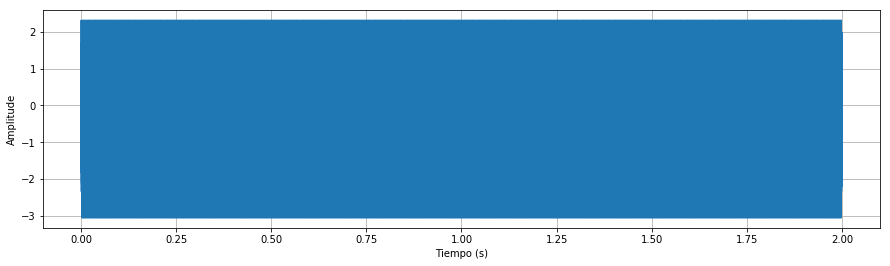

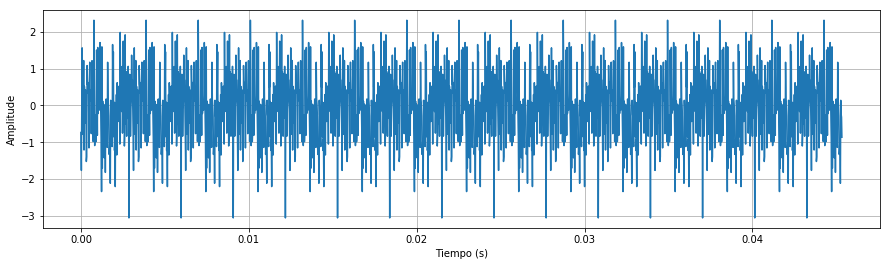

In [29]:
N=fs*2

y=KS(xn, N)

plt.figure(figsize=(15,4))
t=np.arange(len(y))/fs
plt.plot(t,y)
plt.grid()
plt.xlabel("Tiempo (s)")
plt.ylabel("Amplitude")

plt.figure(figsize=(15,4))
t=np.arange(len(y))/fs
plt.plot(t[0:2000],y[0:2000]) # zoom de la señal
plt.grid()
plt.xlabel("Tiempo (s)")
plt.ylabel("Amplitude")


plt.show()

Audio(y,rate=fs)



3. Calcule y grafique la transformada de Fourier de la señal creada y <span style="color:red"> Concluya<span>

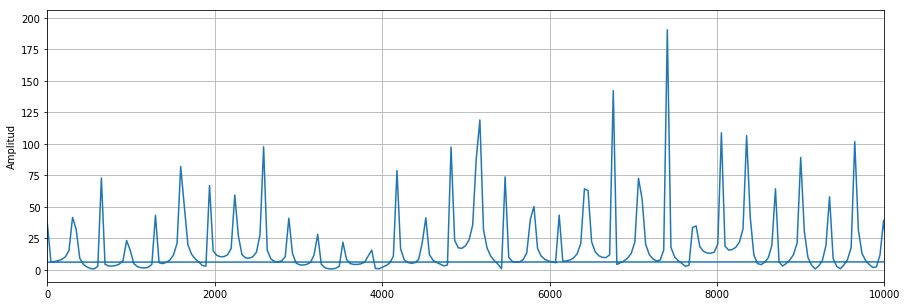

In [6]:
Y = np.fft.fft(y, n=1024)
 
Y = np.abs(Y)

freq = np.fft.fftfreq(n=1024, d=1/fs)
plt.figure(figsize=(15,5))
plt.plot(freq, Y)
plt.xlim(0,10000)
plt.ylabel("frecuencia (Hz)")
plt.ylabel("Amplitud")
plt.grid()
plt.show()



4. <span style="color:red">Genere otros dos tonos con duraciones  $T_{02}=80$ y $T_{03}=440$. ¿Cuál es la frecuencia fundamental para ambos tonos?. ¿Que diferencia percibe al escuchar los dos tonos que acaba de generar? </span>


5. <span style="color:red"> Calcule la transformada de Fourier para ambas señales con $T_{02}=80$ y $T_{03}=440$, comparelas y concluya </span>

## Mejora del algoritmo KS

Como pudo notar, los sonidos generados por el sintetizador son muy simples y de nota musical sólo tiene la frecuencia fundamental. Sin embargo, es posible obtener notas un poco más de realistas. Para esto, se agrega un término de atenuación $\alpha$ a la ecuación del sintetizador, de la siguiente forma:

$$  y[n] = x[n]+\alpha y[n-L] $$


1. De acuerdo a la Ecuación anterior, modifique la función KS de tal forma que se incluya la constante $\alpha$, la cual debe ser un parámetro de entrada de la función. $\alpha$ siempre toma valores menores que 1 (Generalmente se asumen valores entre 0.9 y 1). 

In [7]:
def KS2(x, N, alpha):
    """
    Entradas:
    x: Señal de entrada del sintetizador
    N: Duración de la señal de salida
    alpha: factor de atenuación (0<alpha<1)
    Salida:
    y: Sonido sintetizado
    """
    # Longitud de x(n)
    L = len(x)
    # Preparar la salida
    y = np.zeros(N)
    # Asumimos condiciones inciales igual a cero (y[n]=0 para n < 0)
    for n in range(0, N):
        y[n] = (x[n] if n < L else 0) + (alpha*y[n-L] if n-L >= 0 else 0)
    return y

2. Genere nuevamente un tono con $f_0=320~Hz$ usando ruido blanco Gaussiano como excitación, utilizando la función modificada. Grafique la señal de salida del sintetizador, y su transformada de Fourier.

<span style="color:red"> Que cambios nota con respecto a lo obtenido previamente? </span>

<span style="color:red"> Que ocurre cuando se utilizan otros valores de alpha? </span>



In [30]:
def generate_signal(alpha, F0):
    T0=int(fs/F0) #T0 es el periodo de la señal de entrada
    xn = np.random.randn(T0)  # señal de entrada al sistema

    y=KS2(xn, N, alpha)


    plt.figure(figsize=(15,4))
    t=np.arange(len(y))/fs
    plt.plot(t,y) # zoom de la señal
    plt.grid()
    plt.xlabel("Tiempo (s)")
    plt.ylabel("Amplitud")
    
    Y = np.fft.fft(y, n=1024)
    Y = np.abs(Y)

    freq = np.fft.fftfreq(n=1024, d=1/fs)
    plt.figure(figsize=(15,4))
    plt.plot(freq, Y)
    plt.xlim(0,10000)
    plt.ylabel("frecuencia (Hz)")
    plt.ylabel("Amplitud")
    plt.grid()
    plt.show()

    plt.show()

    return y

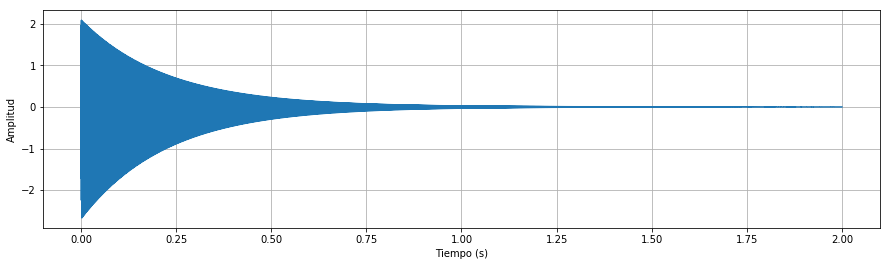

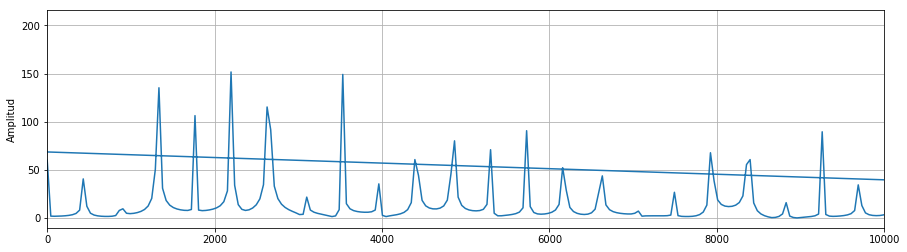

In [33]:
y=generate_signal(0.99, 440)
Audio(y,rate=fs)

Ahora, genere y escuche tres tonos con $f_0\in \{100,500,1600\}~Hz$. 

<span style="color:red">¿Qué sucede con el sonido sintetizado a medida que se aumenta la frecuencia fundamental?. </span>

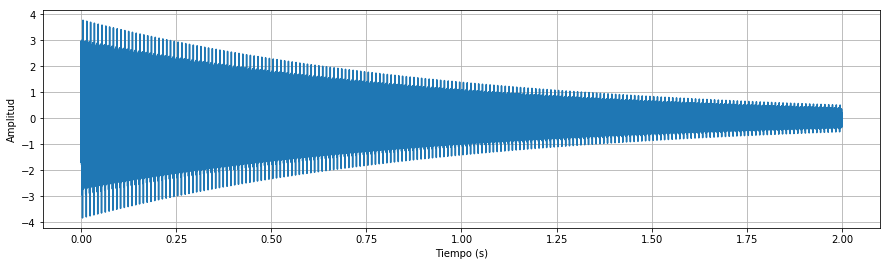

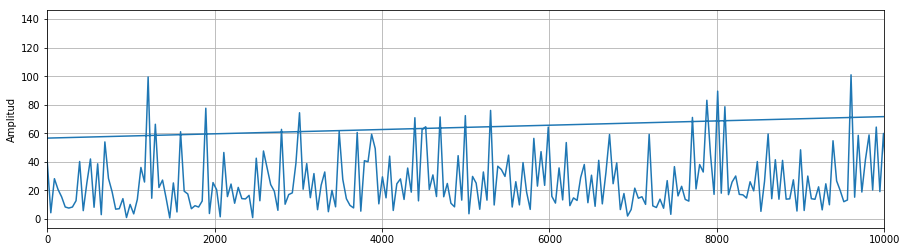

In [34]:
y=generate_signal(0.99, 100)
Audio(y,rate=fs)

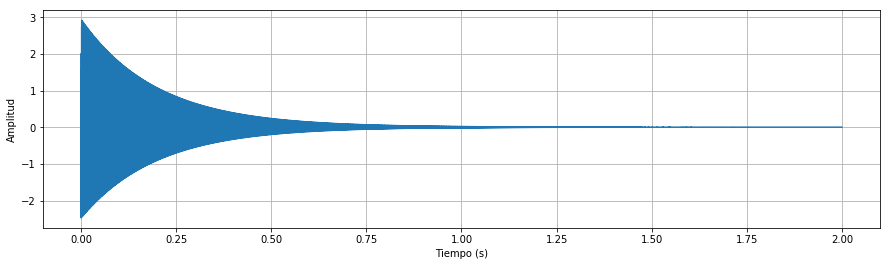

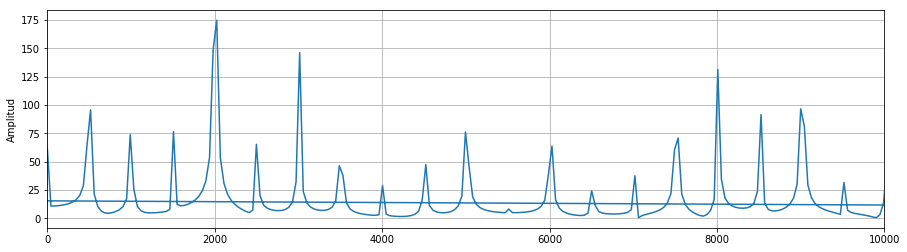

In [11]:
y=generate_signal(0.99, 500)
Audio(y,rate=fs)

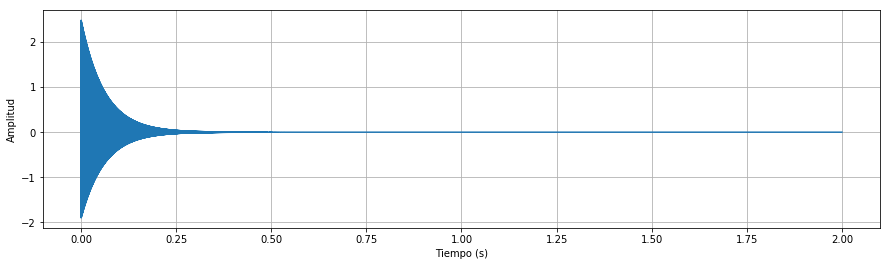

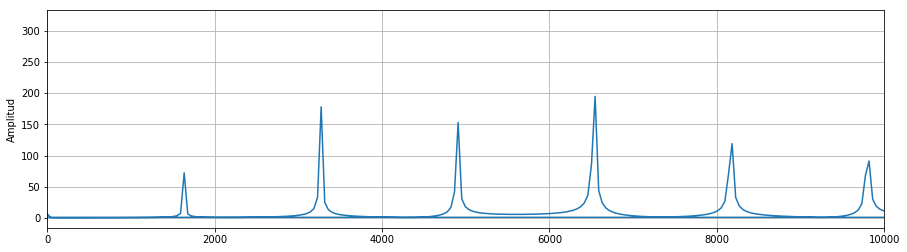

In [12]:
y=generate_signal(0.99, 1600)
Audio(y,rate=fs)

## Un último ajuste del algoritmo KS

Si identificó correctamente el problema en el numeral anterior, entonces estará de acuerdo en que es necesario hacer un ajuste en la atenuación para sintetizar adecuadamente ciertas notas musicales.

1. Modifique la función KS2 de tal forma que el parámetro de atenuación sea $\alpha_n=\alpha^{L/L_{ref}}$, donde $L_{ref}$ es la duración $T_0$ de una señal de referencia. Tomaremos $L_{ref}=50$ como duración de referencia. $L$ es la longitud de la señal de entrada.

In [35]:
def KS3(x, N, alpha):
    """
    Entradas:
    x: Señal de entrada del sintetizador
    N: Duración de la señal de salida
    alpha: factor de atenuación (0<alpha<1)
    Salida:
    y: Sonido sintetizado
    """
    # Longitud de x(n)
    L = len(x)
    Lref=50
    alpha_n=alpha**(L/Lref)
    # Preparar la salida
    y = np.zeros(N)
    # Asumimos condiciones inciales igual a cero (y[n]=0 para n < 0)
    for n in range(0, N):
        y[n] = (x[n] if n < L else 0) + (alpha_n*y[n-L] if n-L >= 0 else 0)
    return y

Genere nuevamente los tonos con $f_0\in \{100,500,1600\}~Hz$, utilizando la nueva función KS3. 

<span style="color:red"> ¿Qué cambio introdujo el nuevo $\alpha_n$ en la síntesis de las notas musicales?. </span>

In [36]:
def generate_signal(alpha, F0):
    T0=int(fs/F0) #T0 es el periodo de la señal de entrada
    xn = np.random.randn(T0)  # señal de entrada al sistema

    y=KS3(xn, N, alpha)


    plt.figure(figsize=(20,5))
    t=np.arange(len(y))/fs
    plt.plot(t,y) # zoom de la señal
    plt.grid()
    plt.xlabel("Tiempo (s)")
    plt.ylabel("Amplitud")
    
    Y = np.fft.fft(y, n=1024)
    Y = np.abs(Y)

    freq = np.fft.fftfreq(n=1024, d=1/fs)
    plt.figure(figsize=(20,5))
    plt.plot(freq, Y)
    plt.xlim(0,10000)
    plt.ylabel("frecuencia (Hz)")
    plt.ylabel("Amplitud")
    plt.grid()
    plt.show()

    plt.show()

    return y
    


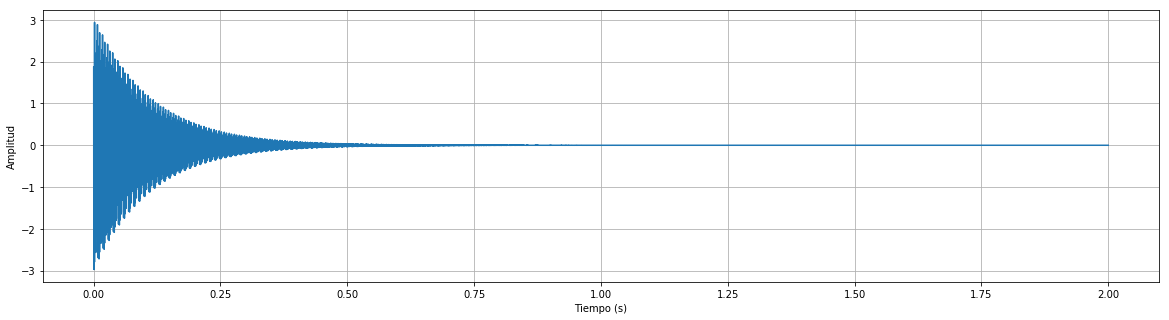

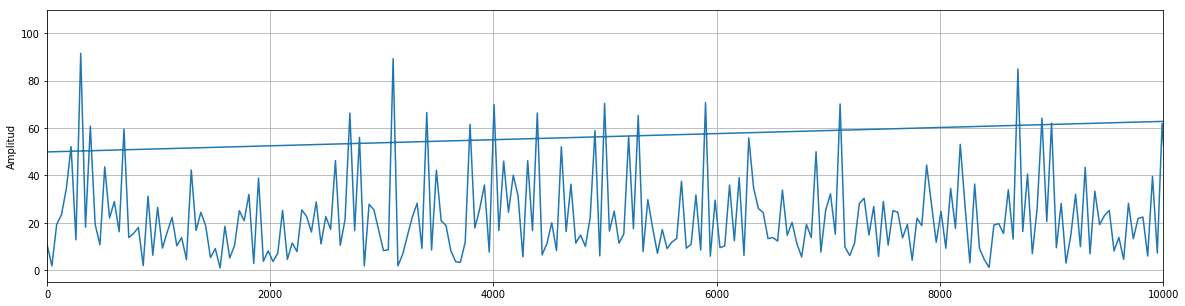

In [37]:
y=generate_signal(0.99, 100)
Audio(y,rate=fs)

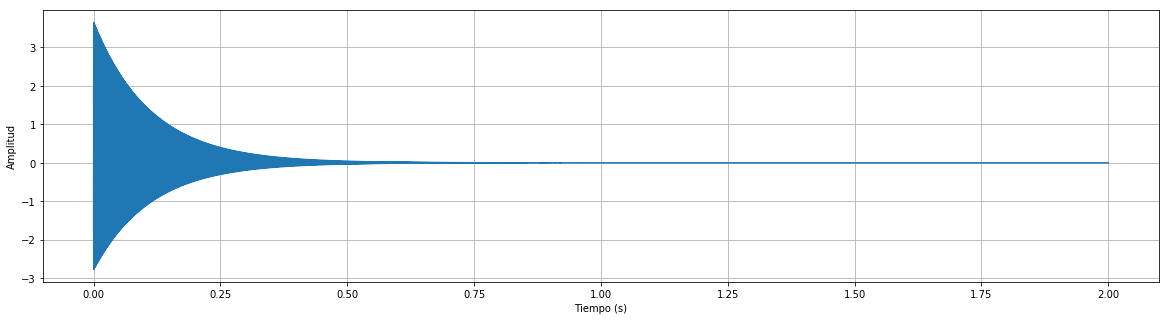

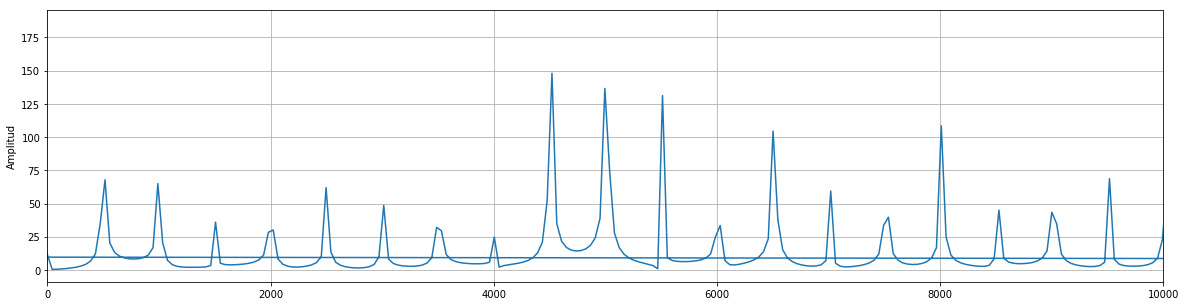

In [38]:
y=generate_signal(0.99, 500)
Audio(y,rate=fs)

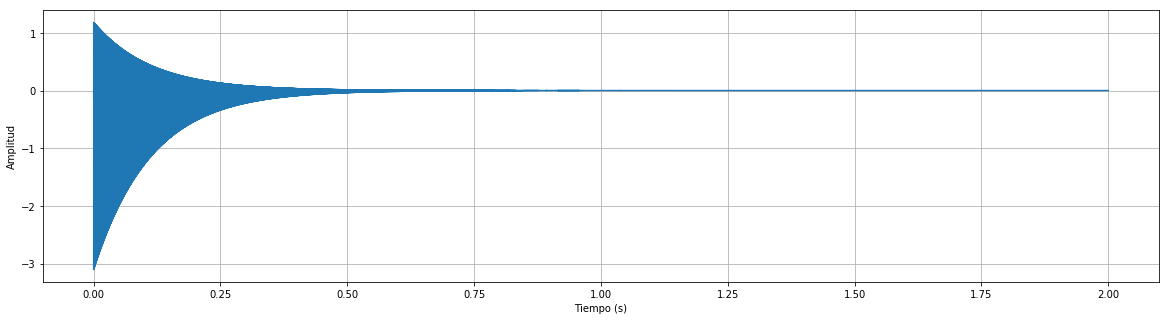

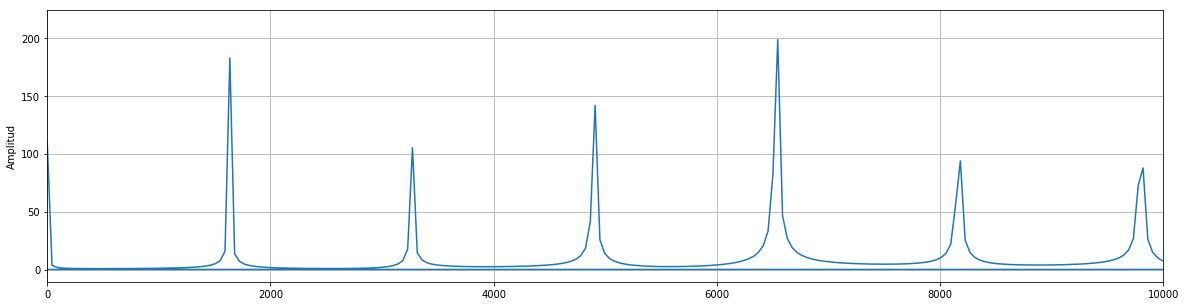

In [39]:
y=generate_signal(0.99, 1600)
Audio(y,rate=fs)

# Composición de melodias

Finalmente vamos a implementar algunas funciones que nos permitirán componer un poco de música, de acuerdo con una notacion estandar (Ver figura)

<img src="https://www.keytarhq.com/wp-content/uploads/piano-notes.jpg">

In [18]:
def freq(note):
    # Esta funcion nos permite convertir una nota con notacion 
    #general en su correspondiente frecuencia fundamental en Hz
    if len(note) < 2 or len(note) > 3 or \
        note[0] < 'A' or note[0] > 'G':
        return 0
    if len(note) == 3:
        if note[1] == 'b':
            acc = -1
        elif note[1] == '#':
            acc = 1
        else:
            return 0
        octave = int(note[2])
    else:
        acc = 0
        octave = int(note[1])
    SEMITONES = {'A': 0, 'B': 2, 'C': -9, 'D': -7, 'E': -5, 'F': -4, 'G': -2}
    n = 12 * (octave - 4) + SEMITONES[note[0]] + acc
    f = 440 * (2 ** (float(n) / 12.0))
    #print note, f
    return f
    
def ks_concatenate(notes, alpha, fs, time_step=1):
    # esta funcion recibe una secuencia de notas, 
    # luego busca su frecuencia asociada en Hz,  y genera el tono correspondiente usando el algoritmo KS
    # los tonos generados luego son concatenados, creando una melodia completa
    y = []
    for note, duration in (notes):
        # Crear un buffer incial KS con datos aleatorios
        x = np.random.randn(int(np.round(float(fs) / freq(note))))
        y.append(KS3(x, int(duration*fs*time_step), alpha))
    return np.concatenate(y)

## Ejemplo

In [23]:
tune1 = (('B3', 2), ('B4', 2), ('F#4', 2), ('D#4', 2), ('B4', 1), ('F#4', 3), ('D#4', 4), 
    ('C4', 2), ('C5', 2), ('G4', 2),  ('E4', 2),  ('C5', 1), ('G4', 3),  ('E4', 4),
    ('B3', 2), ('B4', 2), ('F#4', 2), ('D#4', 2), ('B4', 1), ('F#4', 3), ('D#4', 4), 
    ('D#4', 1), ('E4', 1), ('F4', 2), ('F4', 1), ('F#4', 1), ('G4', 2), ('G4', 1), 
    ('G#4', 1), ('A4', 2), ('B4', 4))

y=ks_concatenate(tune1, 0.999, fs, time_step=0.07)
Audio(y, rate=fs)

In [24]:
tune2 = (('E3', 1), ('E3', 0.5), ('G3', 0.5), ('E3', 0.5), ('D3', 0.5), 
    ('C3', 1), ('B2', 2))
y=ks_concatenate(tune2, 0.999, fs, time_step=0.7)
Audio(y, rate=fs)

Como último ejemplo, se  pueden combinar notas para formar un acorde complejo, de la siguiente  forma

In [25]:
def ks_chord(chord, N, alpha, fs):
    y = np.zeros(N)
    # the chord is a dictionary: pitch => gain
    for note, gain in chord:
        # create an initial random-filled KS buffer the note
        x = np.random.randn(int(np.round(float(fs) / freq(note))))
        y = y + gain * KS3(x, N, alpha)
    return y  

In [26]:
hdn_chord = [
    ['D2' , 2.2], 
    ['D3' , 3.0], 
    ['F3' , 1.0], 
    ['G3' , 3.2], 
    ['F4' , 1.0], 
    ['A4' , 1.0], 
    ['C5' , 1.0], 
    ['G5' , 3.5],
]

y=ks_chord(hdn_chord, 4*fs, 0.995, fs)

Audio(y, rate=fs)

El acorde original puede ser escuchado en el siguiente enlace

https://upload.wikimedia.org/wikipedia/en/c/c4/A_Hard_Day's_Night_opening_chord.ogg

Bastante cerca no?

<span style="color:red"> ¿Qué se puede concluir de este último punto? </span>

<span style="color:red"> Con los ejemplos suministrados, genere una melodía propia. Puede usar varias notas y combinarlas para crear un sonido agradable al oído. </span>